In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

model_path = os.path.join(models_base_path, "letters_continuous_allletters/2/epoch_300_ckpt.pth")

In [5]:
# Define the branches
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

# classes = [letter_to_class[l] for l in ("A", "V", "Y")]
# branch_defs = [
#     (("A", "V", "Y"), 0.65, 1),
#     (("A",), 0, 0.65),
#     (("V", "Y"), 0.35, 0.65),
#     (("V",), 0, 0.35),
#     (("Y",), 0, 0.35)
# ]

classes = [letter_to_class[l] for l in letters]
branch_defs = [(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'), 0.5235235235235235, 1), (('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5165165165165165, 0.5235235235235235), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5115115115115115, 0.5165165165165165), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4944944944944945, 0.5115115115115115), (('I', 'J'), 0.4794794794794795, 0.4944944944944945), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4724724724724725, 0.4944944944944945), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.45645645645645644, 0.4724724724724725), (('F', 'P', 'T', 'V', 'Y'), 0.4364364364364364, 0.4724724724724725), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.4174174174174174, 0.45645645645645644), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4134134134134134, 0.4174174174174174), (('B', 'D', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4094094094094094, 0.4134134134134134), (('F', 'T', 'V', 'Y'), 0.4024024024024024, 0.4364364364364364), (('B', 'D', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3863863863863864, 0.4094094094094094), (('B', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3813813813813814, 0.3863863863863864), (('B', 'G', 'H', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3733733733733734, 0.3813813813813814), (('F', 'T', 'Y'), 0.36036036036036034, 0.4024024024024024), (('C', 'E'), 0.3563563563563564, 0.4134134134134134), (('T', 'Y'), 0.3533533533533533, 0.36036036036036034), (('B', 'R', 'S', 'X', 'Z'), 0.35135135135135137, 0.3733733733733734), (('G', 'H', 'O', 'Q'), 0.34134134134134136, 0.3733733733733734), (('B', 'S', 'X', 'Z'), 0.32232232232232233, 0.35135135135135137), (('B', 'S', 'X'), 0.27627627627627627, 0.32232232232232233), (('G', 'H', 'O'), 0.26426426426426425, 0.34134134134134136), (('G', 'O'), 0.25725725725725723, 0.26426426426426425), (('S', 'X'), 0.15615615615615616, 0.27627627627627627), (('W',), 0, 0.5235235235235235), (('A',), 0, 0.5165165165165165), (('L',), 0, 0.5115115115115115), (('J',), 0, 0.4794794794794795), (('I',), 0, 0.4794794794794795), (('M',), 0, 0.45645645645645644), (('P',), 0, 0.4364364364364364), (('U',), 0, 0.4174174174174174), (('N',), 0, 0.4094094094094094), (('V',), 0, 0.4024024024024024), (('D',), 0, 0.3863863863863864), (('K',), 0, 0.3813813813813814), (('F',), 0, 0.36036036036036034), (('E',), 0, 0.3563563563563564), (('C',), 0, 0.3563563563563564), (('Y',), 0, 0.3533533533533533), (('T',), 0, 0.3533533533533533), (('R',), 0, 0.35135135135135137), (('Q',), 0, 0.34134134134134136), (('Z',), 0, 0.32232232232232233), (('B',), 0, 0.27627627627627627), (('H',), 0, 0.26426426426426425), (('G',), 0, 0.25725725725725723), (('O',), 0, 0.25725725725725723), (('S',), 0, 0.15615615615615616), (('X',), 0, 0.15615615615615616)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

input_shape = (16,)

In [6]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/letters_hybrid_transmutation"

os.makedirs(out_path, exist_ok=True)

In [8]:
branch_point_examples = [
    (letter_to_class["E"], letter_to_class["F"], 0.4724724724724725),
    (letter_to_class["O"], letter_to_class["X"], 0.5235235235235235)
]

### Create data loader

In [9]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [10]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the model

In [11]:
model = model_util.load_model(
    table_dnn.MultitaskTabularNet, model_path
).to(DEVICE)

### Hybrids

Branch point between E and F


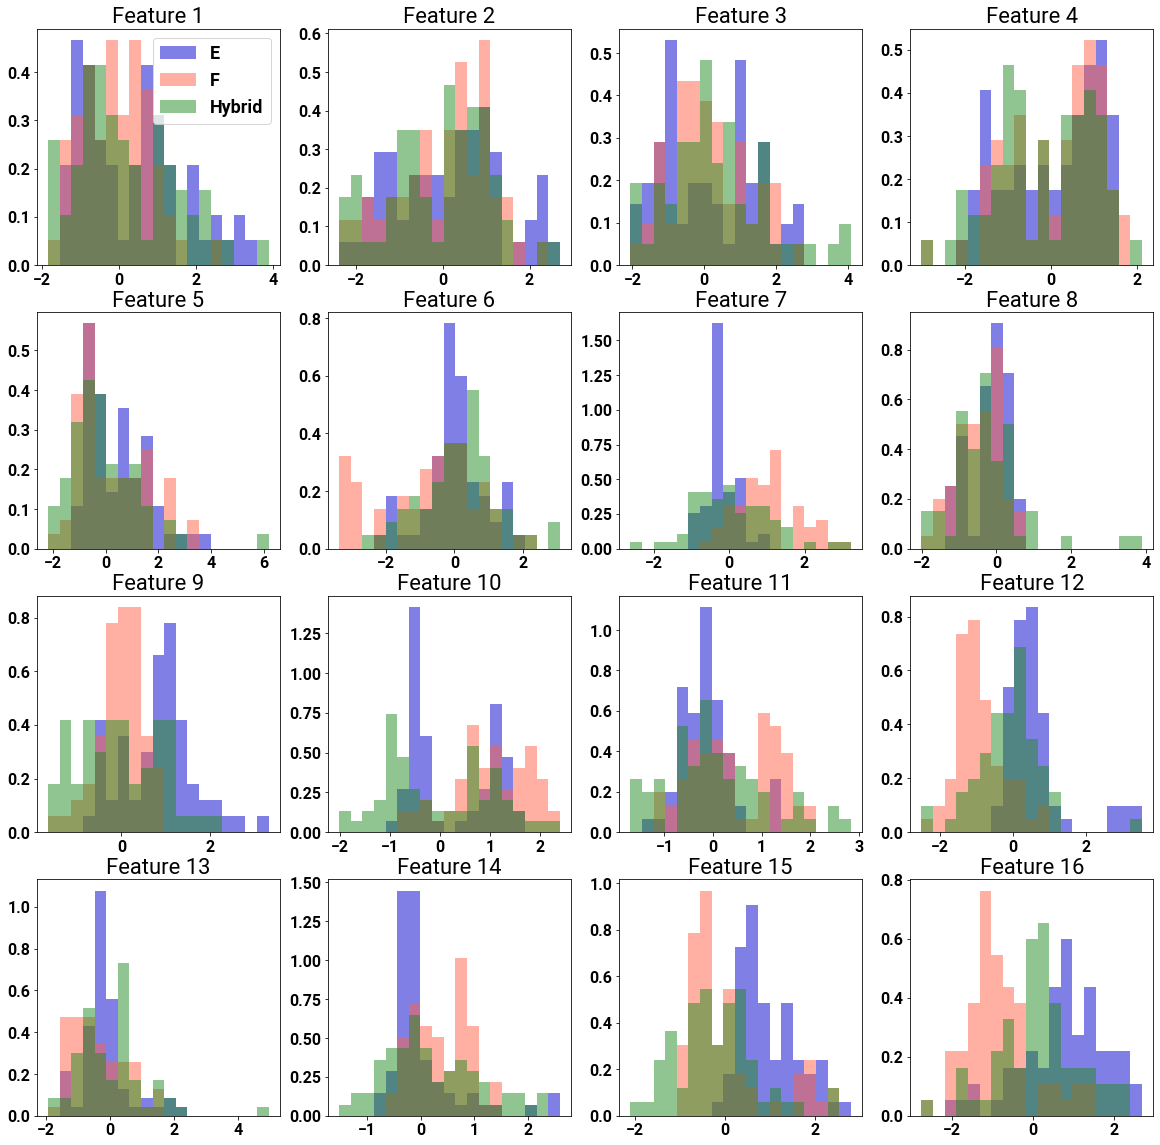

Branch point between O and X


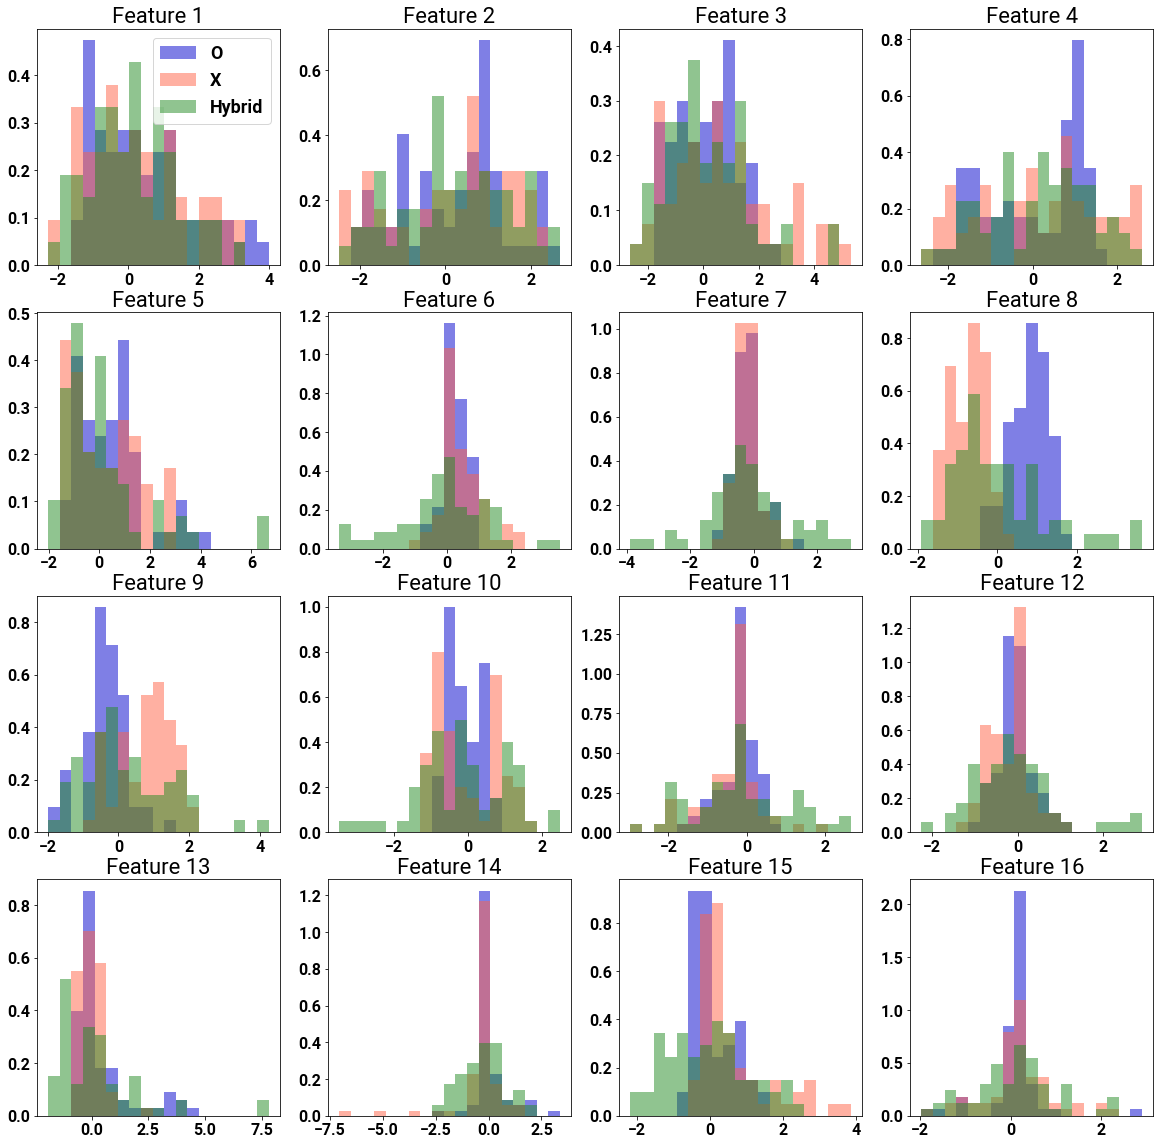

In [12]:
for class_1, class_2, branch_time in branch_point_examples:
    print("Branch point between %s and %s" % (class_to_letter[class_1], class_to_letter[class_2]))
    samples_12 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_start=branch_time,
        t_limit=t_limit
    ).cpu().numpy()
    samples_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE)
    ).cpu().numpy()
    samples_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE)
    ).cpu().numpy()
    
    # Plot the distribution of features
    num_features = input_shape[0]
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))

    for i in range(num_features):
        r, c = i // num_cols, i % num_cols
        data_to_plot = {}
        vals_1, vals_2, vals_12 = np.ravel(samples_1[:, i]), np.ravel(samples_2[:, i]), np.ravel(samples_12[:, i])
        all_vals = np.concatenate([vals_1, vals_2, vals_12])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(vals_1, bins=bins, label=class_to_letter[class_1], density=True, alpha=0.5, color="mediumblue")
        ax[r][c].hist(vals_2, bins=bins, label=class_to_letter[class_2], density=True, alpha=0.5, color="tomato")
        ax[r][c].hist(vals_12, bins=bins, label="Hybrid", density=True, alpha=0.5, color="forestgreen")
        ax[r][c].set_title("Feature %d" % (i + 1))
    ax[0][0].legend()
    plt.show()
    fig.savefig(
        os.path.join(out_path, "letters_hybrid_%s_%s.svg" % (class_to_letter[class_1], class_to_letter[class_2])),
        format="svg"
    )

### Transmutation

Class E and F


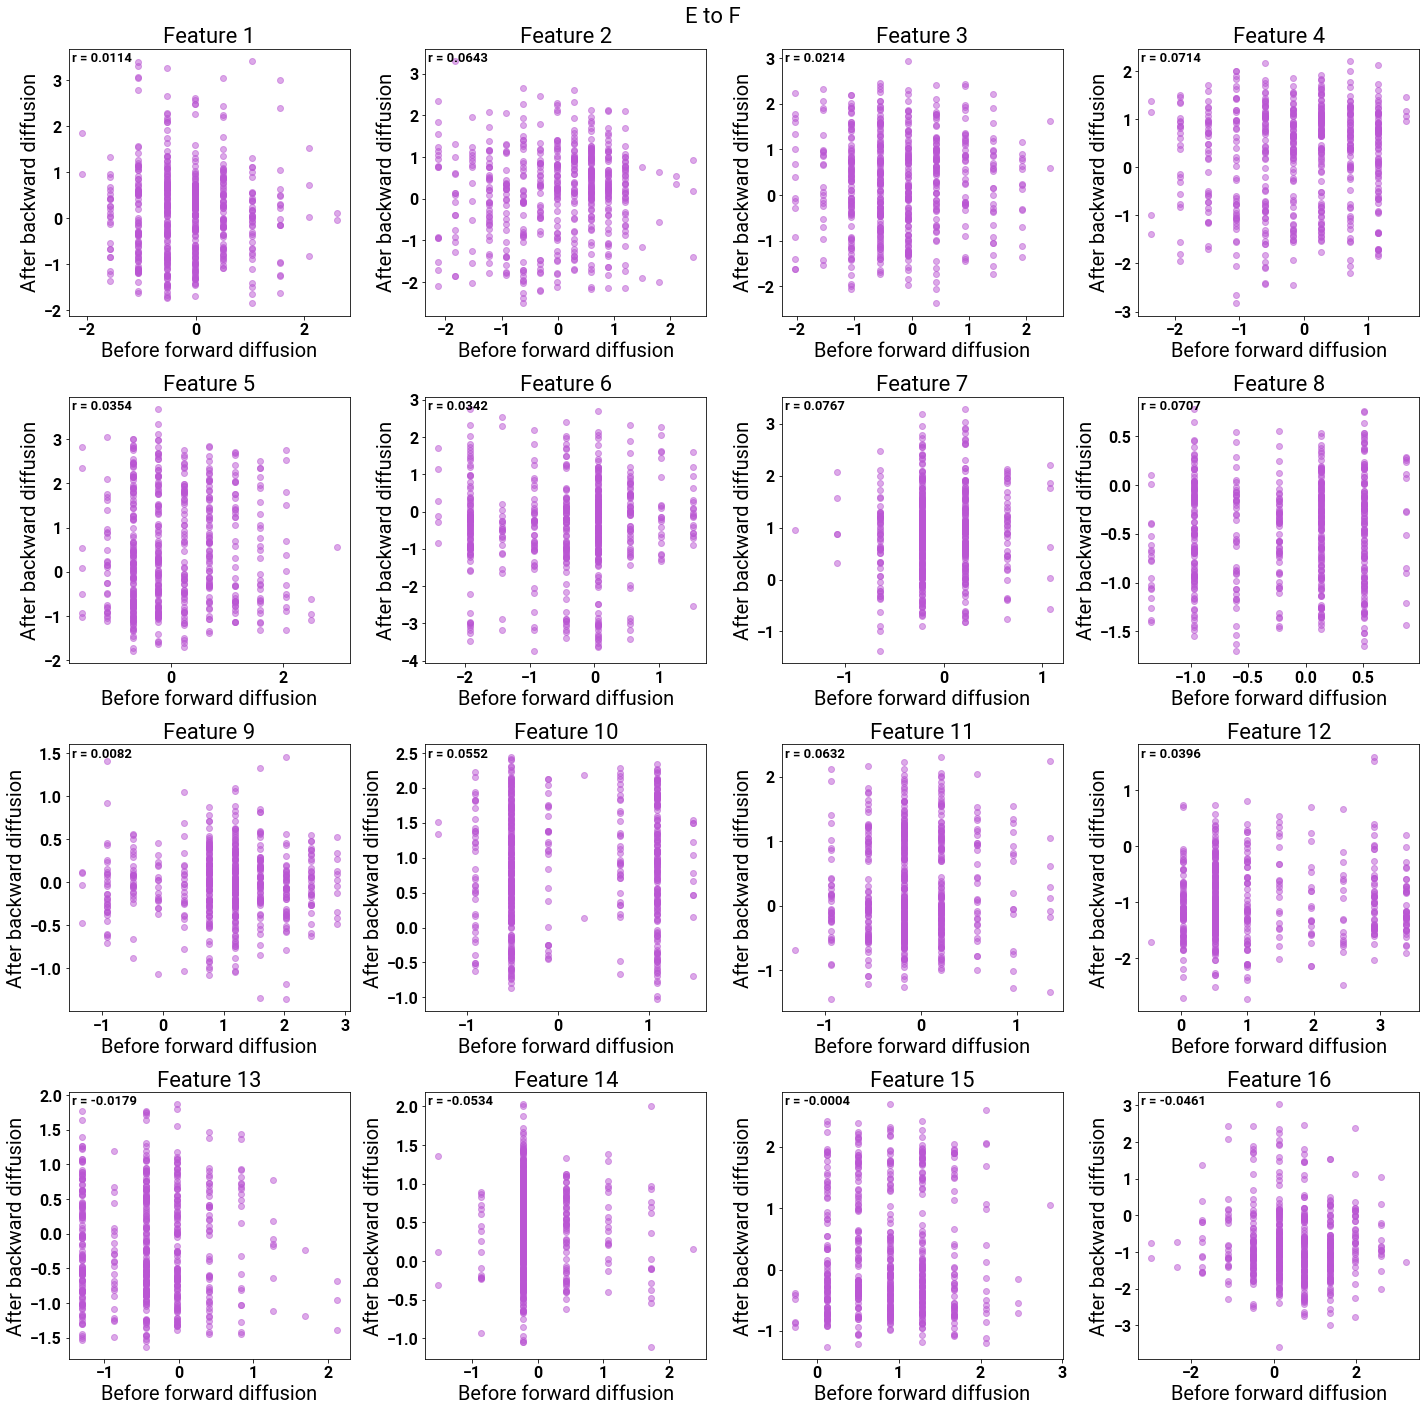

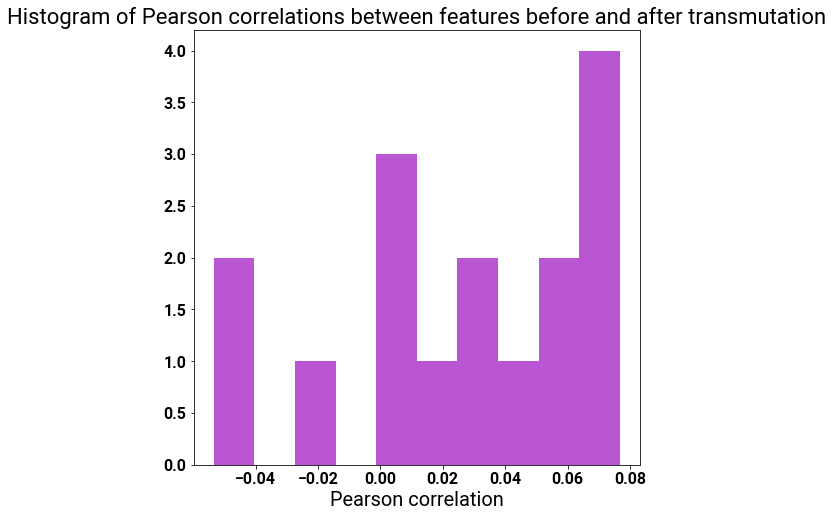

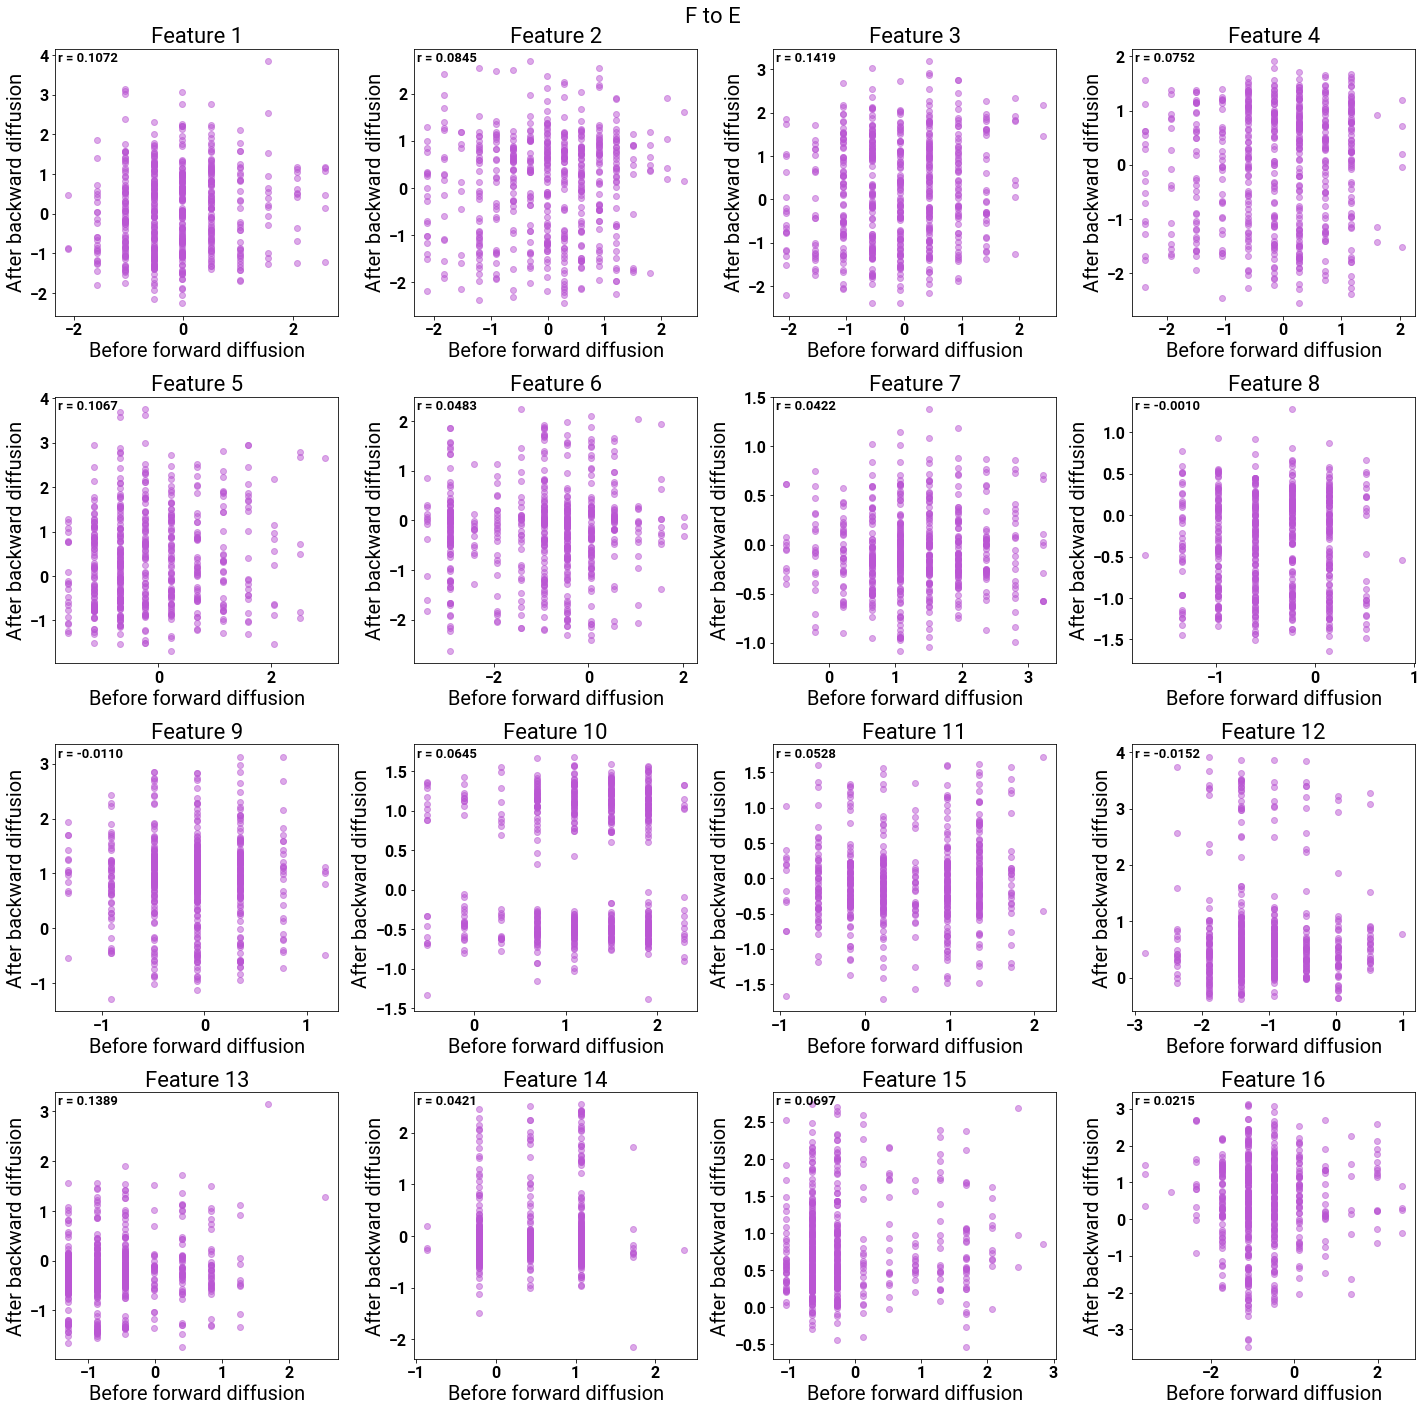

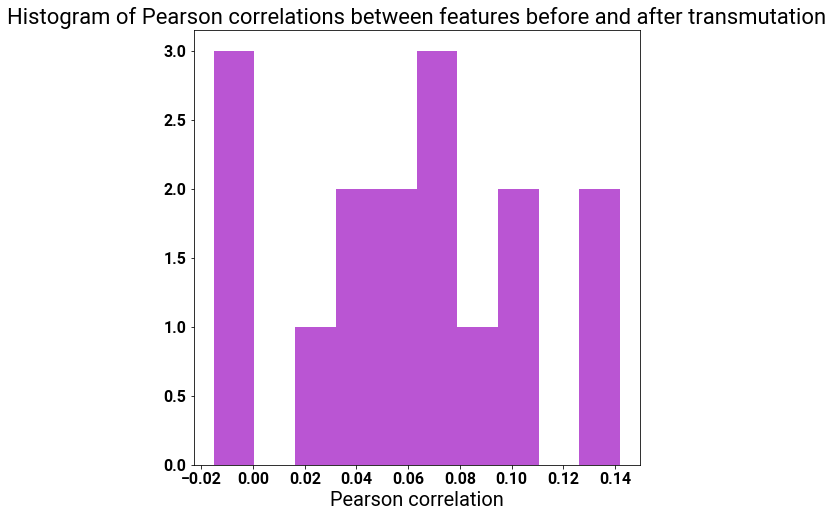

Class O and X


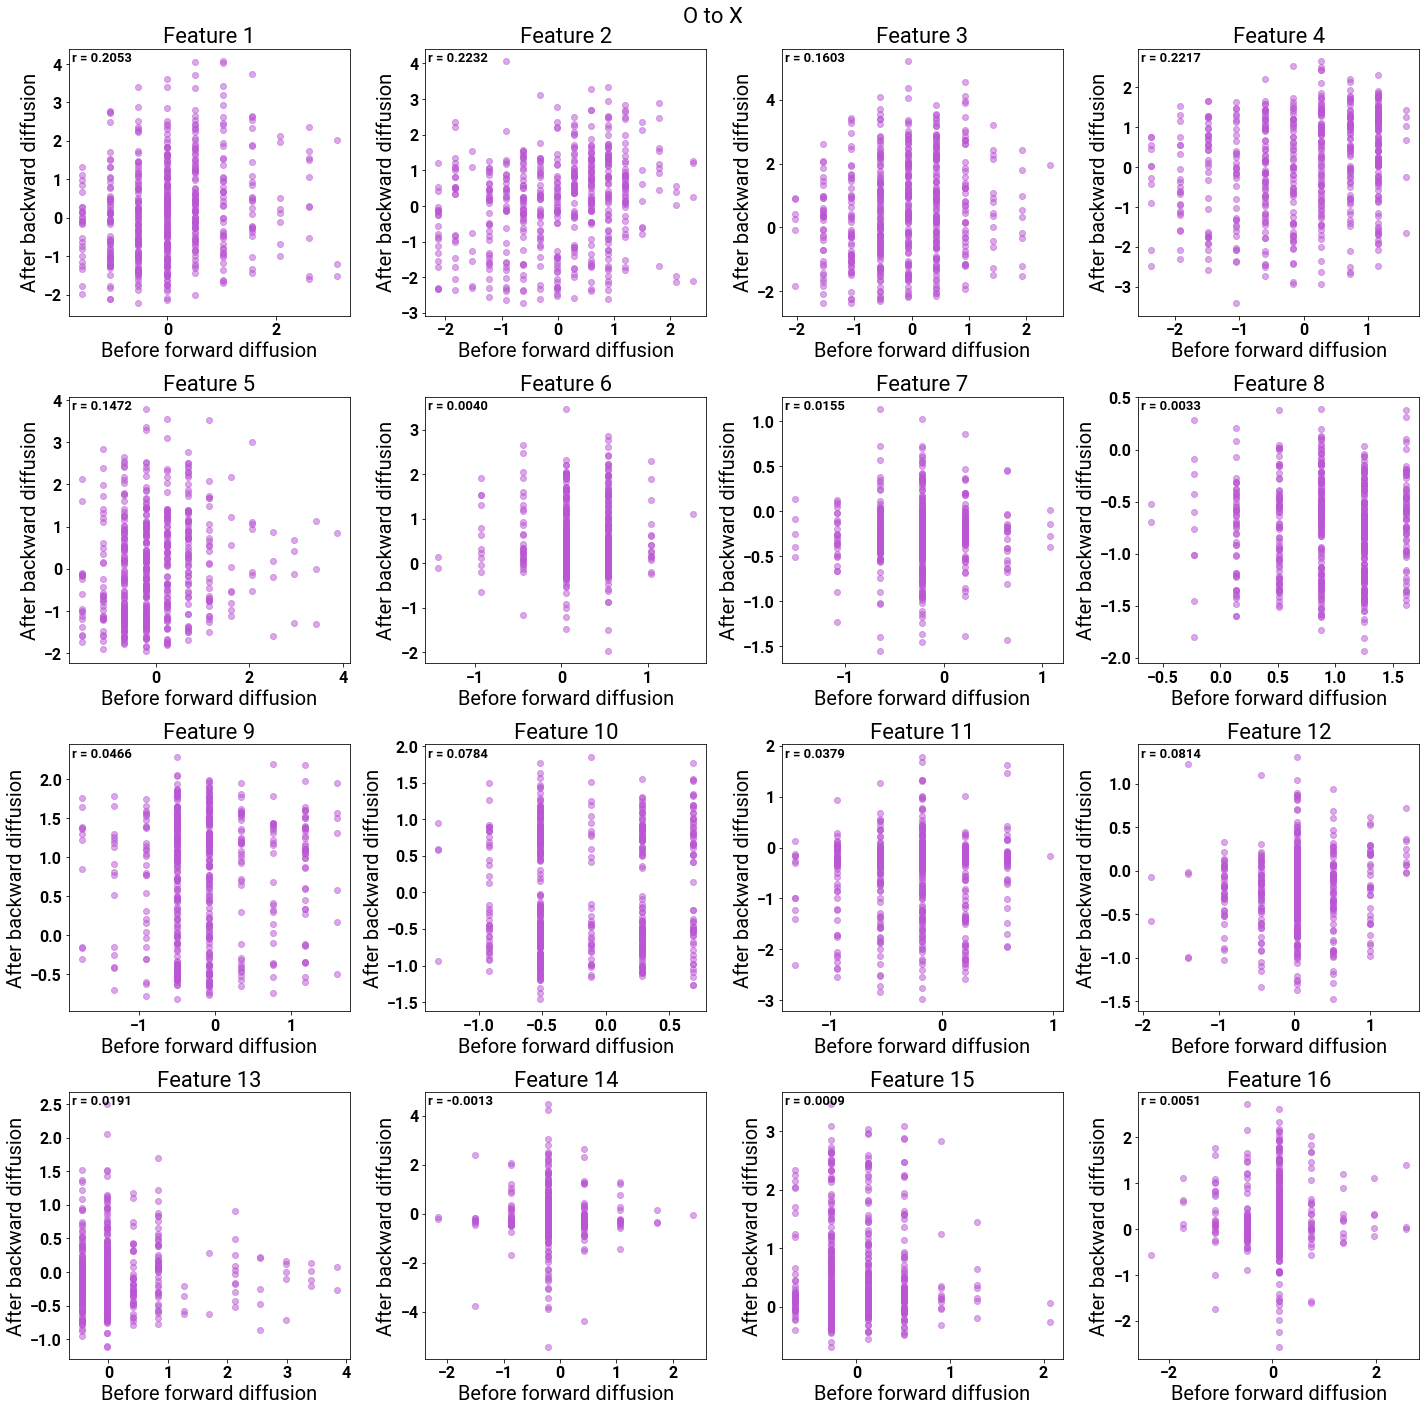

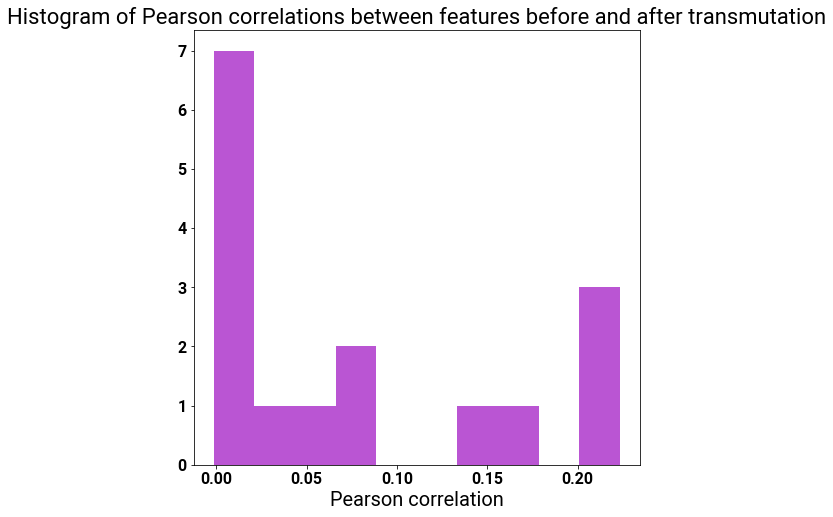

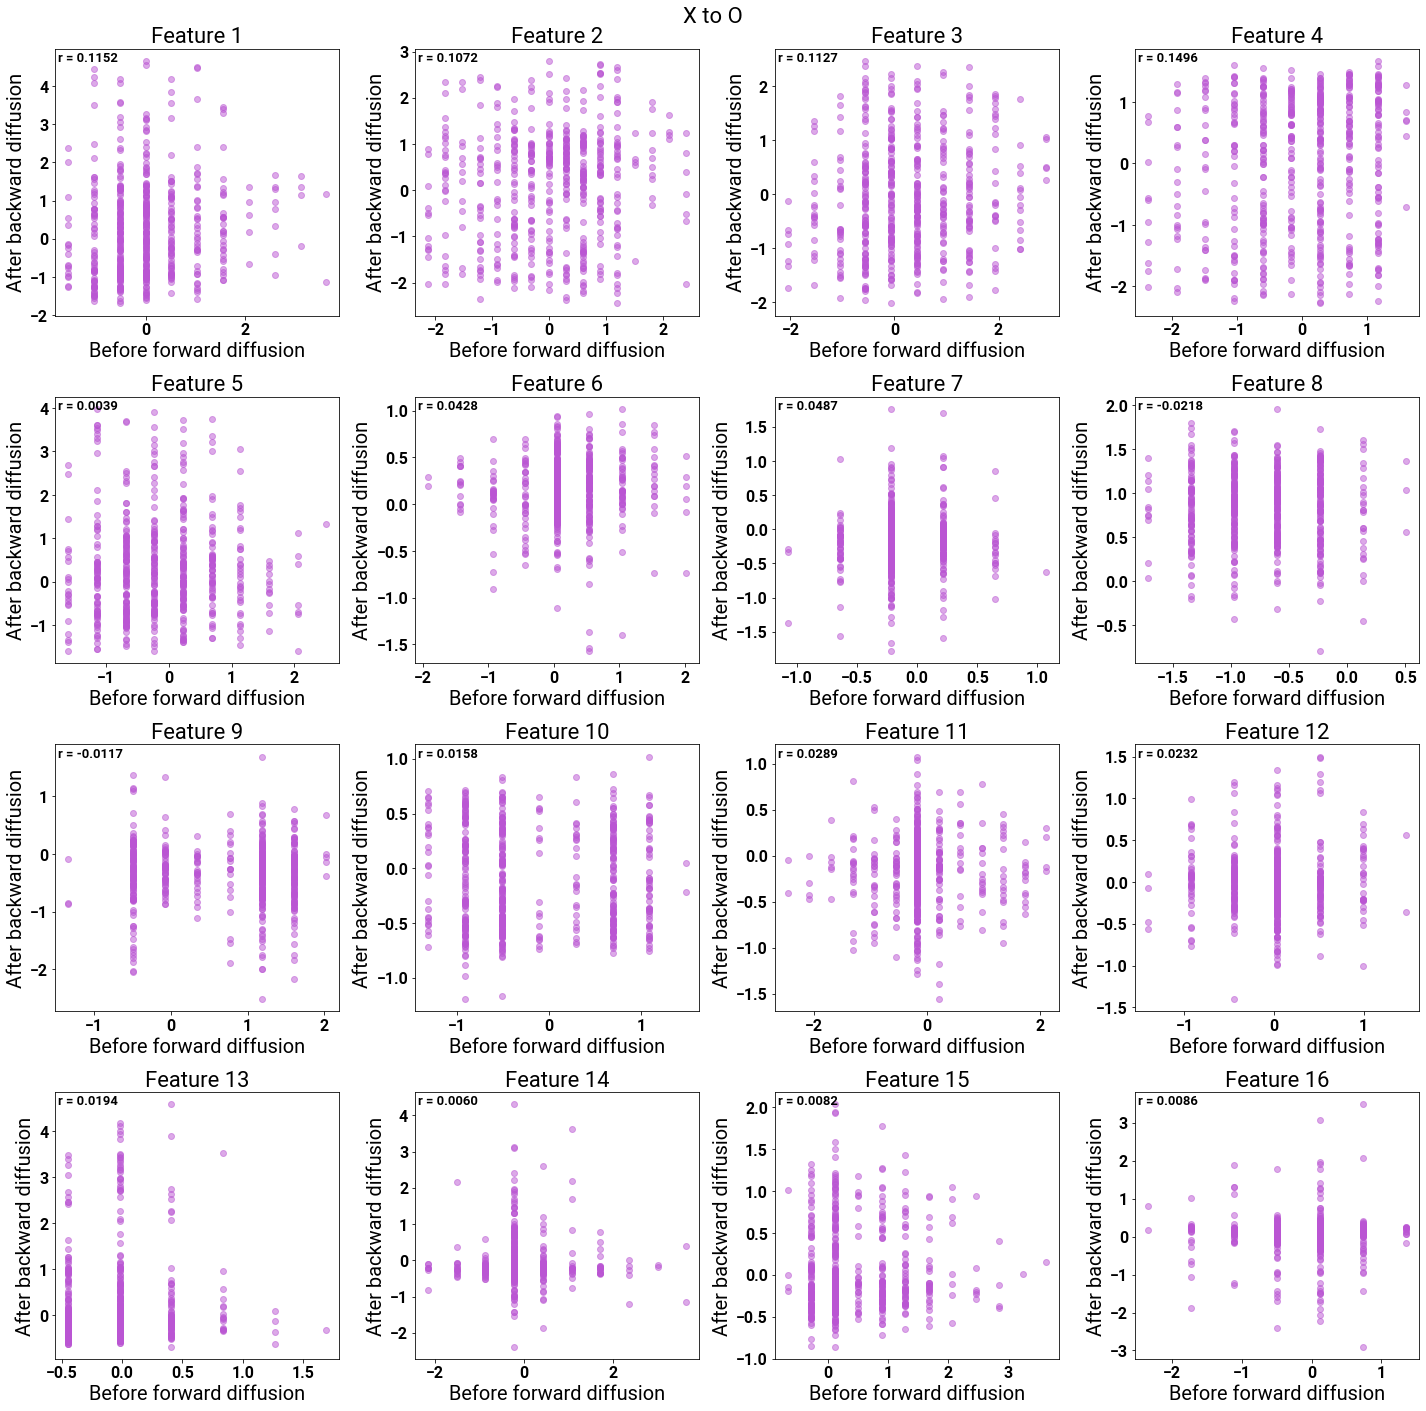

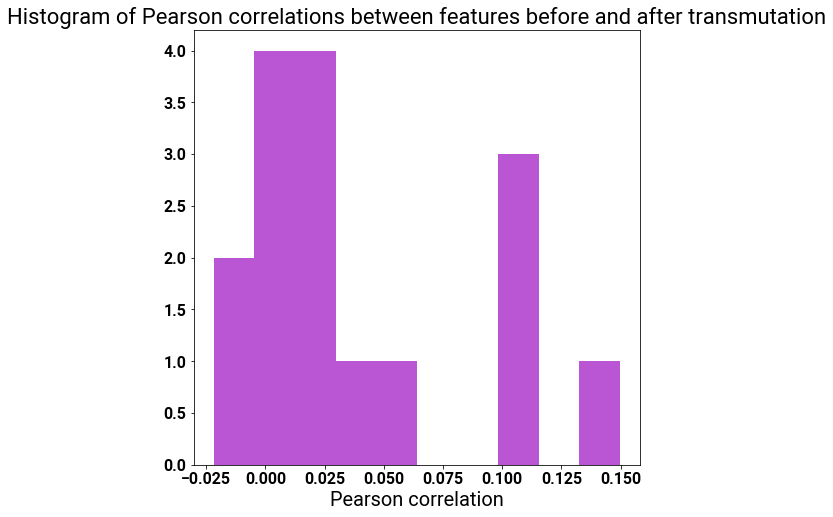

In [13]:
for class_1, class_2, branch_time in branch_point_examples:
    print("Class %s and %s" % (class_to_letter[class_1], class_to_letter[class_2]))
    orig_1 = torch.stack([
        dataset[i][0].to(DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_1)[0], size=512, replace=False)
    ])
    orig_2 = torch.stack([
        dataset[i][0].to(DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_2)[0], size=512, replace=False)
    ])

    time_steps = 10
    all_t = np.linspace(0, branch_time, time_steps)
    forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
    backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
    forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
    backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
    for t_i, t in enumerate(all_t):
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

    all_t_flip = np.flip(all_t)
    last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
    last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
    for t_i in range(len(all_t_flip) - 1):
        last_1_to_2 = generate.generate_continuous_branched_samples(
            model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
            num_steps=50
        )
        backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

        last_2_to_1 = generate.generate_continuous_branched_samples(
            model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
            num_steps=50
        )
        backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

    # Compute correlation of features before and after transmutation
    corrs_1_to_2, corrs_2_to_1 = np.empty(num_features), np.empty(num_features)
    for i in range(num_features):
        corrs_1_to_2[i] = scipy.stats.pearsonr(
            forward_1_to_2[0][:, i], backward_1_to_2[-1][:, i]
        )[0]
        corrs_2_to_1[i] = scipy.stats.pearsonr(
            forward_2_to_1[0][:, i], backward_2_to_1[-1][:, i]
        )[0]

    # Plot correlation of features before and after transmutation
    num_features = input_shape[0]
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    for c1, c2, forwards, backwards in [
        (class_1, class_2, forward_1_to_2[0], backward_1_to_2[-1]),
        (class_2, class_1, forward_2_to_1[0], backward_2_to_1[-1])
    ]:
        corrs = []
        fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
        for i in range(num_features):
            r, c = i // num_cols, i % num_cols
            x, y = forwards[:, i], backwards[:, i]
            corr = scipy.stats.pearsonr(x, y)[0]
            corrs.append(corr)
            ax[r][c].scatter(x, y, alpha=0.5, color="mediumorchid")
            ax[r][c].text(
                0.01, 0.99, "r = %.4f" % corr,
                ha="left", va="top", transform=ax[r][c].transAxes
            )
            ax[r][c].set_xlabel("Before forward diffusion")
            ax[r][c].set_ylabel("After backward diffusion")
            ax[r][c].set_title("Feature %d" % (i + 1))
        fig.suptitle("%s to %s" % (class_to_letter[c1], class_to_letter[c2]))
        fig.tight_layout()
        plt.show()
        fig.savefig(
            os.path.join(out_path, "letters_transmutation_%s_to_%s.svg" % (class_to_letter[c1], class_to_letter[c2])),
            format="svg"
        )
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.hist(corrs, bins=10, color="mediumorchid")
        ax.set_title("Histogram of Pearson correlations between features before and after transmutation")
        ax.set_xlabel("Pearson correlation")
        plt.show()
        fig.savefig(
            os.path.join(out_path, "letters_transmutation_hist_%s_to_%s.svg" % (class_to_letter[c1], class_to_letter[c2])),
            format="svg"
        )